<a href="https://colab.research.google.com/github/Jack-The-Ripper-1820/GAN_VAE/blob/main/GAN_FACE_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
import zipfile
import pandas as pd

In [ ]:
zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/Face Dataset/archive.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
PIC_DIR = f'/tmp/img_align_celeba/img_align_celeba/'
IMAGES_COUNT = 10000
ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
WIDTH = 128
HEIGHT = 128
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)
images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open('/tmp/img_align_celeba/img_align_celeba/' + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))

100%|██████████| 10000/10000 [00:23<00:00, 421.36it/s]


In [ ]:
images = np.array(images) / 255
print(images.shape)

(10000, 128, 128, 3)


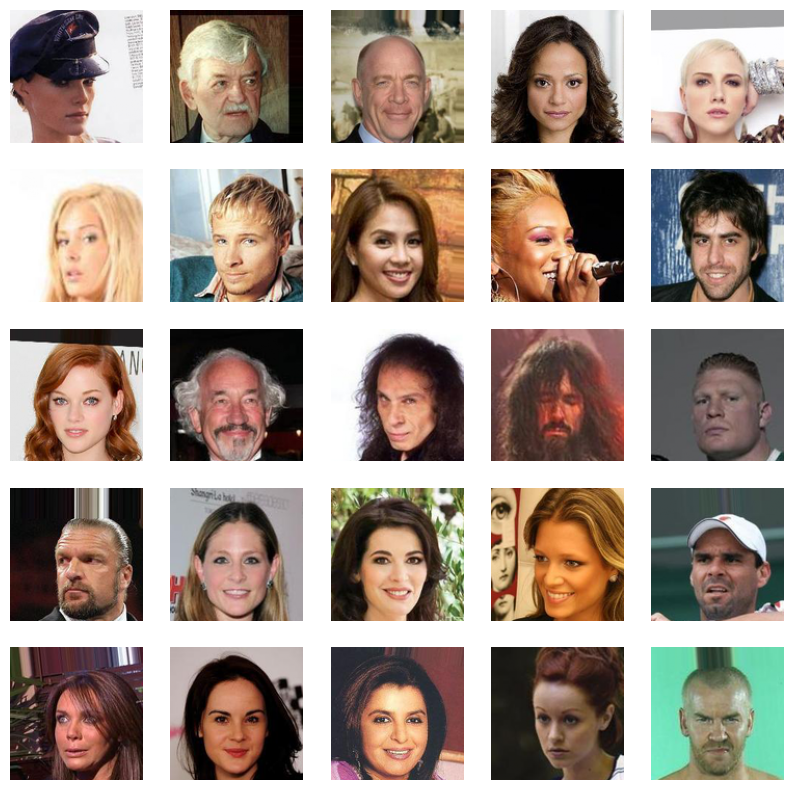

In [ ]:
plt.figure(1, figsize=(10, 10))
for i in range(25,50):
    j=i-25
    plt.subplot(5, 5, j+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:
LATENT_DIM = 32
CHANNELS = 3

In [ ]:
def make_generator():
    model = Sequential()

    model.add(Dense(128 * 16 * 16, input_shape=(LATENT_DIM, )))
    model.add(LeakyReLU())
    model.add(Reshape((16, 16, 128)))

    model.add(Conv2D(256, 5, padding='same'))
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(256, 4, strides=2, padding='same'))
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(256, 4, strides=2, padding='same'))
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(256, 4, strides=2, padding='same'))
    model.add(LeakyReLU())
    
    model.add(Conv2D(512, 5, padding='same'))
    model.add(LeakyReLU())
    model.add(Conv2D(512, 5, padding='same'))
    model.add(LeakyReLU())
    
    model.add(Conv2D(CHANNELS, 7, activation='tanh', padding='same'))

    return model

In [ ]:
def make_discriminator():
    model = Sequential()
    
    model.add(Conv2D(256, 3, input_shape=(HEIGHT, WIDTH, CHANNELS)))
    model.add(LeakyReLU())
    
    model.add(Conv2D(256, 4, strides=2))
    model.add(LeakyReLU())
    
    model.add(Conv2D(256, 4, strides=2))
    model.add(LeakyReLU())
    
    model.add(Conv2D(256, 4, strides=2))
    model.add(LeakyReLU())
    
    model.add(Conv2D(256, 4, strides=2))
    model.add(LeakyReLU())
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )
    
    return model


In [ ]:
generator = make_generator()
discriminator = make_discriminator()
discriminator.trainable = False
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)#Adversarial Model
optimizer = RMSprop(learning_rate=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      1048832   
 nspose)                                                         
                                                        

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 256)     7168      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 126, 126, 256)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 256)       1048832   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 62, 62, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       1048832   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 256)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 256)      

In [ ]:
iters = 1000
batch_size = 16
RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2
start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)
    
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)
    
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    
    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    
    if step % 100 == 99:
        gan.save_weights('gan.h5')
        
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        
        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1


1/1 [==============================] - 0s 27ms/step
100/1000: d_loss: 0.7569,  a_loss: 1.4671.  (2.2 sec)
1/1 [==============================] - 0s 19ms/step
200/1000: d_loss: 0.7318,  a_loss: 1.2371.  (2.4 sec)
1/1 [==============================] - 0s 19ms/step
300/1000: d_loss: 0.7261,  a_loss: 1.1559.  (2.3 sec)
1/1 [==============================] - 0s 30ms/step
400/1000: d_loss: 0.5354,  a_loss: 1.0937.  (2.8 sec)
1/1 [==============================] - 0s 20ms/step
500/1000: d_loss: 0.7270,  a_loss: 1.7009.  (2.2 sec)
1/1 [==============================] - 0s 18ms/step
600/1000: d_loss: 0.6834,  a_loss: 0.7251.  (2.4 sec)
1/1 [==============================] - 0s 18ms/step
700/1000: d_loss: 0.6618,  a_loss: 0.9658.  (2.3 sec)
1/1 [==============================] - 0s 28ms/step
800/1000: d_loss: 0.6844,  a_loss: 0.8430.  (2.5 sec)
1/1 [==============================] - 0s 20ms/step
900/1000: d_loss: 0.7065,  a_loss: 0.8229.  (2.4 sec)
1/1 [==============================] - 0s 18ms

1/1 [==============================] - 35s 35s/step


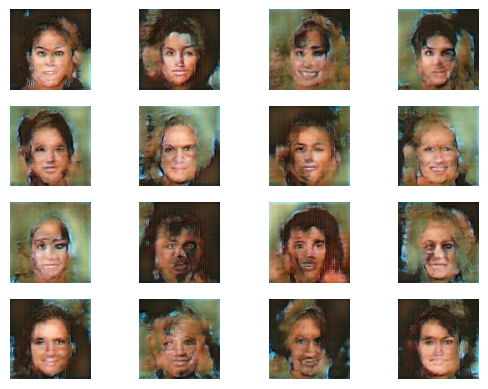

In [ ]:
import numpy as np
from PIL import Image

# Load the saved generator model
gan.load_weights('gan.h5')

# Generate some latent vectors
latent_vectors = np.random.normal(size=(25, LATENT_DIM))

fake_images = generator.predict(latent_vectors)

# plot generated images
fig, axs = plt.subplots(4, 4)
cnt = 0
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(fake_images[cnt, :, :, :])
        axs[i, j].axis('off')
        cnt += 1
plt.show()